<a href="https://colab.research.google.com/github/Jmountford3/Portfolio-/blob/main/Churn_Prediciton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Customer Churn Calculator**

The aim of this project is to calculate the churn rate for customers from the fictional company 'telco', that provides home phone and internet services to over 7000 customers in California.

Logistic regression will be implemented in an attempt to distnguish between customers that are likely to stay and customers that are likely to stop using telco as their providor.

The relevant skills on display in this project include: data cleansing, model choice and exploritry data analysis.

In [41]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier
import xgboost as xgb
from collections import Counter

In [2]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/Portfolio')
warnings.filterwarnings('ignore')

Mounted at /content/drive


In [3]:
import kagglehub

# Download latest dataset from kaggle
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'telco-customer-churn' dataset.
Path to dataset files: /kaggle/input/telco-customer-churn


#**Exploritary Data Analysis**

To fully understand how to create the model to achieve the best results, in depth data analytsis must be carried out.



**A general outline of all the differnt data points that are stored for each individual customer is beneficial, as it lets us see exactly what data is stored about each customer and how excatly it is stored.**

In [4]:
data = pd.read_csv(f'{path}/WA_Fn-UseC_-Telco-Customer-Churn.csv')
display(data.head())

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


None

,count
Churn,
No,5174
Yes,1869


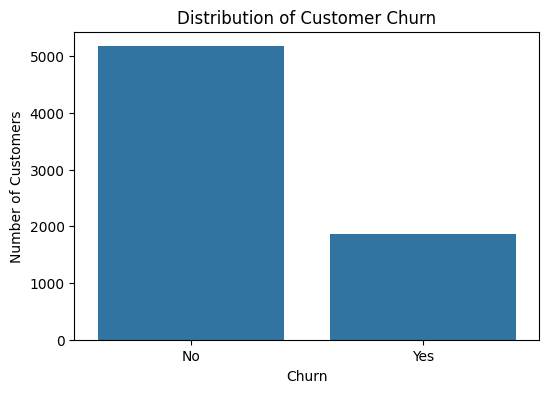

In [6]:
# Calculate the counts of churn and no-churn customers
churn_counts = data['Churn'].value_counts()

# Display the counts
display(churn_counts)

# Create a bar plot of the churn counts
plt.figure(figsize=(6, 4))
sns.barplot(x=churn_counts.index, y=churn_counts.values)
plt.title('Distribution of Customer Churn')
plt.xlabel('Churn')
plt.ylabel('Number of Customers')
plt.show()

In [7]:
display(data.describe())

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [8]:
# Convert 'TotalCharges' to numeric, coercing errors to NaN
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

In [9]:
display(data.isnull().sum())

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [10]:
data['TotalCharges'].fillna(data['TotalCharges'].mean(), inplace=True) # changing the null values with the mean of other values in TotalCharges

In [11]:
display(data.isnull().sum())

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


,count
Churn,
No,5174
Yes,1869


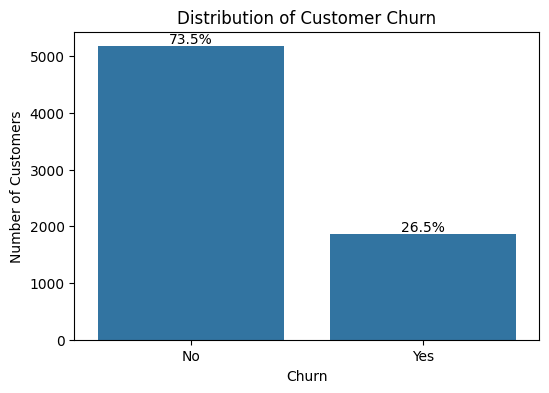

In [12]:
# Calculate the counts of churn and no-churn customers
churn_counts = data['Churn'].value_counts()

# Calculate the percentages
total_customers = churn_counts.sum()
churn_percentages = (churn_counts / total_customers) * 100

# Display the counts
display(churn_counts)

# Create a bar plot of the churn counts
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=churn_counts.index, y=churn_counts.values)
plt.title('Distribution of Customer Churn')
plt.xlabel('Churn')
plt.ylabel('Number of Customers')

# Add percentages to the bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 50,
            '{:1.1f}%'.format(height/total_customers*100),
            ha="center")

plt.show()

Churn,No,Yes
gender,,
Female,2549,939
Male,2625,930


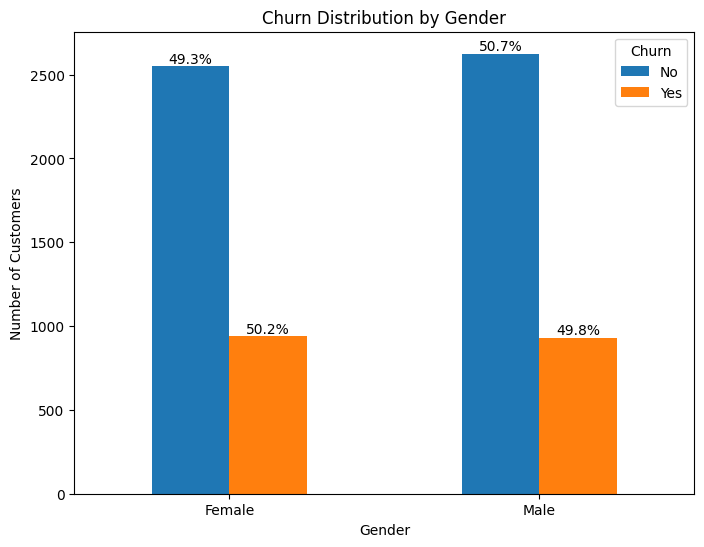

In [13]:
# Calculate the counts of churn for each gender
gender_churn_counts = data.groupby('gender')['Churn'].value_counts().unstack()

# Display the counts
display(gender_churn_counts)

# Calculate the percentages of churn within each gender
gender_churn_percentages = gender_churn_counts.apply(lambda x: x / x.sum() * 100, axis=1)



# Create a grouped bar plot of churn by gender
ax = gender_churn_counts.plot(kind='bar', figsize=(8, 6))
plt.title('Churn Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)

# Add percentages to the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', labels=[f'{p:.1f}%' for p in container.datavalues / container.datavalues.sum() * 100])

plt.show()

In [14]:
data.drop(columns=['customerID'], axis=1, inplace=True) # remove irrelevan features

In [15]:
# Separate features (X) and target variable (y)
# Assuming 'Churn' is your target variable and all other columns except 'customerID' are features
X = data.drop(['Churn'], axis=1)
y = data['Churn']

# Convert categorical features to dummy variables
X = pd.get_dummies(X)

select_features = X.columns

scaler = StandardScaler()
X = scaler.fit_transform(X[select_features])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (5634, 45)
Shape of X_test: (1409, 45)
Shape of y_train: (5634,)
Shape of y_test: (1409,)


In [16]:
# Checking best features
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif  # f_classif ANOVA F-value

selector = SelectKBest(f_classif, k = len(select_features))
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
indices = np.argsort(scores)[::-1]

print('Features importance:')
for i in range(len(scores)):
    print('%.2f %s' % (scores[indices[i]], select_features[indices[i]]))

Features importance:
215.73 Contract_Month-to-month
156.42 tenure
151.66 OnlineSecurity_No
144.25 TechSupport_No
117.89 InternetService_Fiber optic
116.66 Contract_Two year
113.83 PaymentMethod_Electronic check
89.97 OnlineBackup_No
77.78 DeviceProtection_No
64.40 DeviceProtection_No internet service
64.40 StreamingTV_No internet service
64.40 StreamingMovies_No internet service
64.40 OnlineSecurity_No internet service
64.40 OnlineBackup_No internet service
64.40 InternetService_No
64.40 TechSupport_No internet service
48.49 TotalCharges
46.86 PaperlessBilling_Yes
46.86 PaperlessBilling_No
45.53 MonthlyCharges
39.22 Contract_One year
38.00 OnlineSecurity_Yes
34.01 TechSupport_Yes
33.86 Dependents_No
33.86 Dependents_Yes
27.89 SeniorCitizen
26.14 Partner_Yes
26.14 Partner_No
23.66 PaymentMethod_Credit card (automatic)
21.45 StreamingTV_No
20.01 StreamingMovies_No
19.06 InternetService_DSL
15.75 PaymentMethod_Bank transfer (automatic)
11.44 PaymentMethod_Mailed check
9.03 OnlineBackup_Ye

In [29]:
model = RandomForestClassifier(n_estimators= 400, random_state=20)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=400, random_state=20)

In [30]:
predictions = model.predict(X_test)

In [31]:
preds = model.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

          No       0.83      0.91      0.87      1036
         Yes       0.66      0.47      0.55       373

    accuracy                           0.79      1409
   macro avg       0.74      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409



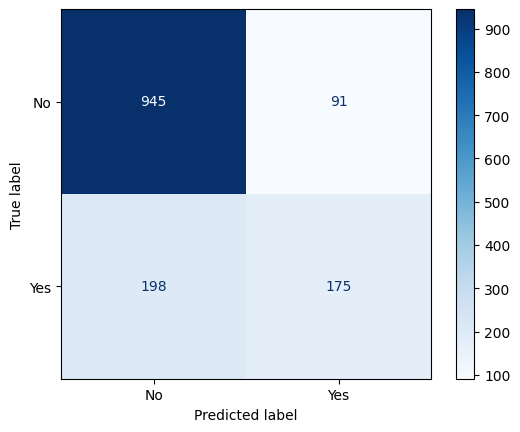

In [32]:
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# SVM

In [17]:
svm = SVC()
svm.fit(X_train, y_train)

SVC()

In [18]:
svm_predictions = svm.predict(X_test)

In [19]:
preds = svm.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

          No       0.84      0.92      0.88      1036
         Yes       0.69      0.53      0.60       373

    accuracy                           0.81      1409
   macro avg       0.77      0.72      0.74      1409
weighted avg       0.80      0.81      0.80      1409



In [20]:
whole_data_x = np.concatenate((X_train, X_test))
whole_data_y = np.concatenate((y_train, y_test))

model = SVC()

grid = dict()
grid['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']

search = GridSearchCV(model, grid, scoring='accuracy', n_jobs=-1)
result = search.fit(whole_data_x, whole_data_y)

print(result)

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy')
Best Score: 0.8003712941157495
Best Hyperparameters: {'kernel': 'linear'}


In [21]:
whole_data_x = np.concatenate((X_train, X_test))
whole_data_y = np.concatenate((y_train, y_test))

model = SVC()

grid = dict()
grid['degree'] = np.arange(1, 10)

search = GridSearchCV(model, grid, scoring='accuracy', n_jobs=-1)
result = search.fit(whole_data_x, whole_data_y)

print(result)

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'degree': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='accuracy')
Best Score: 0.7999451577521131
Best Hyperparameters: {'degree': np.int64(1)}


In [22]:
model = SVC(kernel='linear', degree=1)
model.fit(X_train, y_train)

SVC(degree=1, kernel='linear')

In [23]:
preds = model.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

          No       0.86      0.90      0.88      1036
         Yes       0.69      0.60      0.64       373

    accuracy                           0.82      1409
   macro avg       0.77      0.75      0.76      1409
weighted avg       0.81      0.82      0.82      1409



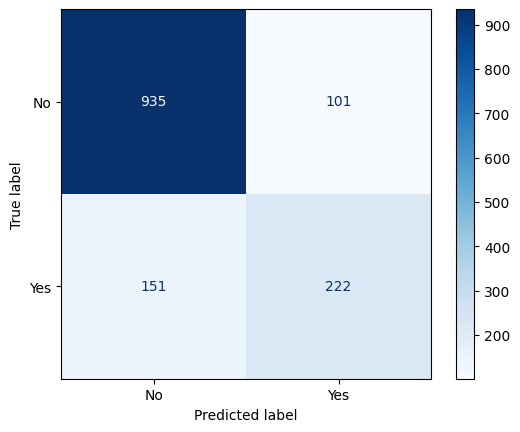

In [28]:
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Nearest Neighbour

In [37]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

KNeighborsClassifier()

In [39]:
pred = model.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

          No       0.83      0.85      0.84      1036
         Yes       0.55      0.51      0.53       373

    accuracy                           0.76      1409
   macro avg       0.69      0.68      0.69      1409
weighted avg       0.76      0.76      0.76      1409



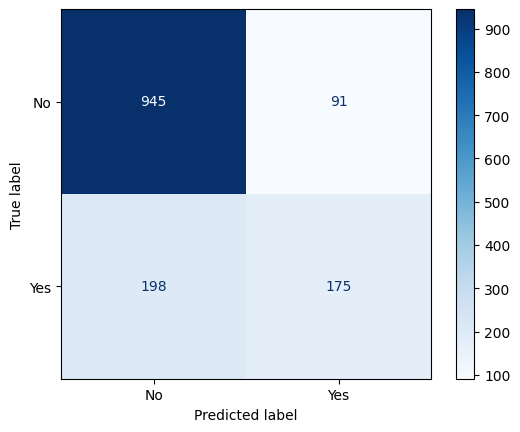

In [40]:
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [42]:
# Choose the number of folds for cross-validation
n_splits = 5

In [43]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

rf_accuracies = []
rf_precisions = []
rf_realls = []
rf_f1s = []
rf_roc_aucs = []

svm_accuracies = []
svm_precisions = []
svm_realls = []
svm_f1s = []
svm_roc_aucs = []

knn_accuracies = []
knn_precisions = []
knn_realls = []
knn_f1s = []
knn_roc_aucs = []


for train_index, val_index in skf.split(whole_data_x, whole_data_y):
    X_train_fold, X_val_fold = whole_data_x[train_index], whole_data_x[val_index]
    y_train_fold, y_val_fold = whole_data_y[train_index], whole_data_y[val_index]

    # RandomForestClassifier
    rf_model = RandomForestClassifier(n_estimators=400, random_state=20)
    rf_model.fit(X_train_fold, y_train_fold)
    rf_preds = rf_model.predict(X_val_fold)

    rf_accuracies.append(accuracy_score(y_val_fold, rf_preds))
    rf_precisions.append(classification_report(y_val_fold, rf_preds, output_dict=True)['Yes']['precision'])
    rf_realls.append(classification_report(y_val_fold, rf_preds, output_dict=True)['Yes']['recall'])
    rf_f1s.append(classification_report(y_val_fold, rf_preds, output_dict=True)['Yes']['f1-score'])
    rf_roc_aucs.append(roc_auc_score(y_val_fold, rf_model.predict_proba(X_val_fold)[:, 1]))

    # SVC
    svm_model = SVC(kernel='linear', degree=1, probability=True) # probability=True is needed for roc_auc_score
    svm_model.fit(X_train_fold, y_train_fold)
    svm_preds = svm_model.predict(X_val_fold)

    svm_accuracies.append(accuracy_score(y_val_fold, svm_preds))
    svm_precisions.append(classification_report(y_val_fold, svm_preds, output_dict=True)['Yes']['precision'])
    svm_realls.append(classification_report(y_val_fold, svm_preds, output_dict=True)['Yes']['recall'])
    svm_f1s.append(classification_report(y_val_fold, svm_preds, output_dict=True)['Yes']['f1-score'])
    svm_roc_aucs.append(roc_auc_score(y_val_fold, svm_model.predict_proba(X_val_fold)[:, 1]))


    # KNeighborsClassifier
    knn_model = KNeighborsClassifier()
    knn_model.fit(X_train_fold, y_train_fold)
    knn_preds = knn_model.predict(X_val_fold)

    knn_accuracies.append(accuracy_score(y_val_fold, knn_preds))
    knn_precisions.append(classification_report(y_val_fold, knn_preds, output_dict=True)['Yes']['precision'])
    knn_realls.append(classification_report(y_val_fold, knn_preds, output_dict=True)['Yes']['recall'])
    knn_f1s.append(classification_report(y_val_fold, knn_preds, output_dict=True)['Yes']['f1-score'])
    knn_roc_aucs.append(roc_auc_score(y_val_fold, knn_model.predict_proba(X_val_fold)[:, 1]))


In [46]:
# Calculate the average performance metrics for each model
avg_rf_accuracy = np.mean(rf_accuracies)
avg_rf_precision = np.mean(rf_precisions)
avg_rf_recall = np.mean(rf_realls)
avg_rf_f1 = np.mean(rf_f1s)
avg_rf_roc_auc = np.mean(rf_roc_aucs)

avg_svm_accuracy = np.mean(svm_accuracies)
avg_svm_precision = np.mean(svm_precisions)
avg_svm_recall = np.mean(svm_realls)
avg_svm_f1 = np.mean(svm_f1s)
avg_svm_roc_auc = np.mean(svm_roc_aucs)

avg_knn_accuracy = np.mean(knn_accuracies)
avg_knn_precision = np.mean(knn_precisions)
avg_knn_recall = np.mean(knn_realls)
avg_knn_f1 = np.mean(knn_f1s)
avg_knn_roc_auc = np.mean(knn_roc_aucs)

# Create a DataFrame to store the average performance metrics
performance_df = pd.DataFrame({
    'Model': ['RandomForestClassifier', 'SVC', 'KNeighborsClassifier'],
    'Accuracy': [avg_rf_accuracy, avg_svm_accuracy, avg_knn_accuracy],
    'Precision': [avg_rf_precision, avg_svm_precision, avg_knn_precision],
    'Recall': [avg_rf_recall, avg_svm_recall, avg_knn_recall],
    'F1-score': [avg_rf_f1, avg_svm_f1, avg_knn_f1],
    'ROC AUC': [avg_rf_roc_auc, avg_svm_roc_auc, avg_knn_roc_auc]
})

# Display the DataFrame
display(performance_df)

,Model,Accuracy,Precision,Recall,F1-score,ROC AUC
0,RandomForestClassifier,0.790001,0.638932,0.484729,0.550496,0.825209
1,SVC,0.800227,0.649655,0.538250,0.588445,0.834096
2,KNeighborsClassifier,0.757631,0.546896,0.516853,0.531153,0.770996


The SVM has shown to the be the best model out of the 3 chosen. This conclusion has been drawn after a stratified K Fold assessment was ran on all 3 models to propoerly test each ones effectivness on the same data.

# ***Formulas***

**Churn rate:**

*(Customers Lost / Customers at the start of Period) * 100*